In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
def get_unique_values(keys, target_key, datatype = float):
    unique_c_values = set()  

    for key in keys:
        if not (target_key + "=") in key:
            continue
        key_value_pairs = key.split(", ")
        for pair in key_value_pairs:
            k, v = pair.split("=") 
            if k == target_key:
                unique_c_values.add(datatype(v))

    unique_c_values_list = sorted(list(unique_c_values))

    return unique_c_values_list

def get_param_value(filename, target_key, value_type = float):
    unique_c_values = set()

    l = filename.split("_")
    
    tmp = l[l.index(target_key) + 1]
    if ".json" in tmp:
        val = value_type(tmp[:-5])
    else:
        val = value_type(tmp)

    return val

In [3]:
import sys
sys.path.append("../")

In [4]:
import json, glob
gate_type = "haar"
error_type = "depol"

n_data = 200
eps_min = 3e-7

sname = f"../results/dnorm_scaling/dnorm_scaling_{gate_type}_{error_type}_ndata_*cfilled.json"
fname_list = glob.glob(sname)
print(fname_list)
ndata_candidates = [get_param_value(_f, "ndata", int) for _f in fname_list]
print("\ncandidates for ndata:")
print(ndata_candidates)
print(f"your choice: {n_data}")

filename = f"../results/dnorm_scaling/dnorm_scaling_{gate_type}_{error_type}_ndata_{n_data}_cfilled.json"

data = json.load(open(filename, "r"))

nondiag_l1_data = data["nondiag_l1_data"]
dnorm_data = data["dnorm_data"]
dnorm_det_data = data["dnorm_det_data"]
tcount_data = data["tcount_data"]

c_list = get_unique_values(nondiag_l1_data.keys(), "c")
J_list = get_unique_values(nondiag_l1_data.keys(), "J", int)
eps_list = [eps for eps in get_unique_values(nondiag_l1_data.keys(), "eps") if eps>= eps_min]

print(f"\n{c_list=}")
print(f"{J_list=}")
print(f"{eps_list=}")

['../results/dnorm_scaling/dnorm_scaling_haar_depol_ndata_200_cfilled.json']

candidates for ndata:
[200]
your choice: 200

c_list=[2.0, 3.0, 5.0, 7.0]
J_list=[1, 3]
eps_list=[3e-07, 1e-06, 3e-06, 1e-05, 3e-05, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03]


In [16]:
import numpy as np
import tqdm
from UnifiedCompiler.utils import circuit_to_unitary
from UnifiedCompiler.coherent.synthesis_general_1Q import get_u3_angles
from UnifiedCompiler import Unified1QGateCompiler

solver_type = "scipy"
c = 2
verbose = 0
J=1

def generate_angles_from_haar_random_1Q(n_data, seed=None):
    from qulacs import QuantumCircuit as QC
    if seed is not None:
        np.random.seed(seed)
    seed_list = np.random.randint(0, 12345678, size = n_data)
    angles_list = []
    for _ in range(n_data):
        # Generate Haar random
        qc = QC(1)
        
        qc.add_random_unitary_gate([0], seed = seed_list[_])
        u = circuit_to_unitary(qc)

        # Get the angles
        angles = get_u3_angles(u)
        angles_list.append(np.copy(angles))
    return np.copy(angles_list)

n_data_det = 10
angles_list = generate_angles_from_haar_random_1Q(n_data_det, seed=1234)
dnorm_det_list = []
tcount_det_list = []
eps_list_det = 10**np.linspace(-12, -1.5, num=25)

for eps in tqdm.tqdm(eps_list_det):
    dnorm_det_arr = []
    tcount_det_arr = []
    for angle in angles_list:
    
    
        compiler = Unified1QGateCompiler(
        angle, 
        gate_type, 
        error_type, 
        solver_type, 
        eps = float(eps), 
        c=c, 
        verbose = verbose, 
        J=J
        )

        compiler._run_deterministic_compilation_general()
        #compiler._run_coherent_compilation_general()

        dnorm_det = compiler.dnorm_det
        tcount_det = compiler.tcount_det
        
        dnorm_det_arr.append(dnorm_det)
        tcount_det_arr.append(tcount_det)
        
    dnorm_det_list.append(np.median(dnorm_det_arr))

    tcount_det_list.append(np.median(tcount_det_arr))

100%|██████████| 25/25 [00:13<00:00,  1.90it/s]


/var/folders/xw/hgtg8nx922g7smt8_4th3hxc0000gn/T/ipykernel_46884/1763773301.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")


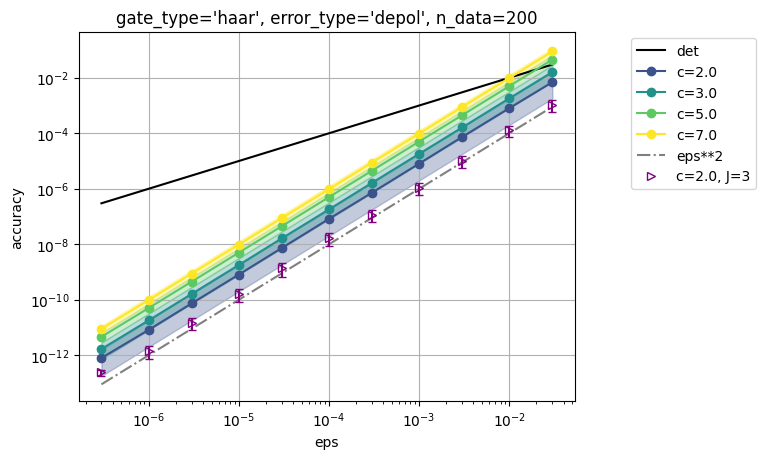

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
%matplotlib inline

cmap = get_cmap("viridis")
l1_threshold = 1e-12

J=1
c_list_disp = c_list
plt.plot(eps_list, eps_list, "-", color = "black", label = "det")

for i, c in enumerate(c_list_disp):
    dnorm_list = []
    dnorm_std_list = []
    for eps in eps_list:
        key = f"eps={eps:.2e}, J={J}, c={c}"
        
        dnorm_raw = dnorm_data[key]
        nondiag_l1_raw = nondiag_l1_data[key]
        
        dnorms = [dnorm for i, dnorm in enumerate(dnorm_raw) if nondiag_l1_raw[i] <= l1_threshold]

        dnorm = np.median(dnorms)
        dnorm_std = np.std(dnorms)
        dnorm_list.append(dnorm)
        dnorm_std_list.append(dnorm_std)
        
    plt.plot(eps_list, dnorm_list, "-o", label = f"{c=}", color = cmap((i+1)/len(c_list_disp)))
    plt.errorbar(eps_list, dnorm_list, yerr = dnorm_std_list, color = cmap((i+1)/len(c_list_disp)), linestyle = "none", capsize = 3)

    dnorm_ub_list = [2*((c+1)*eps)**2 for eps in eps_list]
    dnorm_lb_list = [2*((c-1)*eps)**2 for eps in eps_list]
    plt.fill_between(x = eps_list, y1=dnorm_lb_list, y2 =dnorm_ub_list,color = cmap((i+1)/len(c_list_disp)), alpha = 0.3)


plt.plot(eps_list,np.array(eps_list)**2, "-.", color = "gray", label = "eps**2")    
    
J=J_list[-1]
c=2.0
dnorm_list = []
dnorm_std_list = []
for eps in eps_list:
    key = f"eps={eps:.2e}, J={J}, c={c}"
    
    dnorm_raw = dnorm_data[key]
    nondiag_l1_raw = nondiag_l1_data[key]
    dnorms = [dnorm for i, dnorm in enumerate(dnorm_raw) if nondiag_l1_raw[i] <= l1_threshold]
    
    dnorm = np.median(dnorms)
    dnorm_std = np.std(dnorms)
    dnorm_list.append(dnorm)
    dnorm_std_list.append(dnorm_std)
    
plt.plot(eps_list, dnorm_list, ">", label = f"{c=}, {J=}", color = "purple", markerfacecolor = "none")    
plt.errorbar(eps_list, dnorm_list, yerr = dnorm_std_list, color = "purple", capsize = 3, linestyle = "none")    
    

    
plt.title(f"{gate_type=}, {error_type=}, {n_data=}")

plt.yscale("log")
plt.xscale("log")
plt.ylabel("accuracy")
plt.xlabel("eps")
plt.legend(bbox_to_anchor  = (1.1, 1))
plt.grid()

#figname = f"./figures/dnorm_quad_scaling_{gate_type}_{error_type}_J{J}.pdf"
#plt.savefig(figname, bbox_inches = "tight")
#print(f"...saved as {figname}")